In [1]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
import pandas
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Data pre-processing performed

In [2]:
# load data
path = "Autism-Screening-Child-Data Plus Description/Autism-Child-Data.arff"
from scipy.io.arff import loadarff 
raw_data = loadarff(path)
df_data = pandas.DataFrame(raw_data[0])

# Remove the b'' from the data
str_df = df_data.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_data[col] = str_df[col]

# Make the whole lot categorical
list_of_columns = df_data.columns
df_data[list_of_columns] = df_data[list_of_columns].apply(lambda col:pandas.Categorical(col).codes)

# Remove all rows with negative values
df_data = df_data[(df_data >= 0).all(1)]
    
# split the data to X and y
X = df_data.loc[:, df_data.columns != 'result']
Y = df_data.iloc[:, 17]
#with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df_data)
df_data

<ipython-input-2-b56ce8af1f47>:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_df = df_data.select_dtypes([np.object])


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,...,1,6,0,0,24,0,5,0,2,0
1,1,1,0,0,1,1,0,1,0,0,...,1,5,0,0,24,0,5,0,2,0
2,1,1,0,0,0,1,1,1,0,0,...,1,0,0,0,24,1,5,0,0,0
3,0,1,0,0,1,1,0,0,0,1,...,0,0,1,0,24,0,4,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,1,6,1,0,51,0,10,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1,...,0,10,1,1,50,0,10,0,2,1
288,1,0,0,0,1,0,1,0,0,1,...,0,10,1,1,3,0,4,0,2,0
289,1,0,1,1,1,1,1,0,0,1,...,1,4,0,0,8,0,7,0,2,1
290,1,1,1,0,1,1,1,1,1,1,...,1,8,0,0,18,0,9,0,2,1


# Feature selection

In [3]:
# generate model and get accuracy
def get_accuracy(target_train, target_test, predicted_test, predicted_train):
    clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=2000)
    clf.fit(predicted_train, np.ravel(target_train, order='C'))
    predictions = clf.predict(predicted_test)
    return accuracy_score(target_test, predictions)

pred_train, pred_test, tar_train, tar_test = train_test_split(X, Y, test_size=.3, random_state=4)
print("Accuracy score of our model without feature selection : %.2f" % get_accuracy(tar_train, tar_test, pred_test, pred_train))

# feature extraction
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5, :],"summerize features")
print()
# Now apply only the K most significant features according to the chi square method
pred_features = features[:, 0:5]
pred_train, pred_test, tar_train, tar_test = train_test_split(pred_features, Y, test_size=.3, random_state=2)
print("Accuracy score of our model with chi square feature selection : %.2f" % get_accuracy(tar_train, tar_test, pred_test,pred_train))
print()

## Feature Importance with Extra Trees Classifier
from sklearn.feature_selection import SelectFromModel
# Feature Extraction with RFE
model = LogisticRegression()  # Logistic regression is the Wrapper classifier here
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
## summarize components
#print("Num Features: %d" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
#print("Feature Ranking: %s" % (fit.ranking_))
## Now apply only the K most significant features according to the RFE feature selection method
features = fit.transform(X)
pred_features = features[:, 0:5]
pred_train, pred_test, tar_train, tar_test = train_test_split(pred_features, Y, test_size=.3, random_state=2)
print("Accuracy score of our model with RFE selection : %.2f" % get_accuracy(tar_train, tar_test, pred_test,pred_train))
print()

## Feature Extraction with PCA
## feature extraction
pca = PCA(n_components=5)
fit = pca.fit(X)
features = fit.transform(X)
## summarize components
#print("Explained Variance: %s" % (fit.explained_variance_ratio_))
#print(fit.components_)
## Now apply only the K most significant faetures (components) according to the PCA feature selection method
#features = fit.transform(X)
pred_features = features[:, 0:5]
pred_train, pred_test, tar_train, tar_test = train_test_split(pred_features, Y, test_size=.3, random_state=2)
print("Accuracy score of our model with PCA selection : %.2f" % get_accuracy(tar_train, tar_test, pred_test,pred_train))
print()

## Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
## feature extraction
model = ExtraTreesClassifier(max_depth=3,min_samples_leaf=2)
fit = model.fit(X, Y)
print(model.feature_importances_)
print()
t = SelectFromModel(fit, prefit=True)
features = t.transform(X)
pred_features = features[:, 0:5]
pred_train, pred_test, tar_train, tar_test = train_test_split(pred_features, Y, test_size=.3, random_state=2)
print("Accuracy score of our model with Extra Trees selection : %.2f" % get_accuracy(tar_train, tar_test, pred_test, pred_train))
print()


Accuracy score of our model without feature selection : 0.05
[ 20.321  22.921  21.164  51.545  18.469  33.979  18.496  43.588  56.682
  20.841  26.617   1.917  56.078   5.255   5.473 121.11    1.619     nan
   4.792 149.   ]
[[ 0  0  6 24  0]
 [ 0  0  5 24  0]
 [ 0  0  0 24  0]
 [ 0  0  0 24  0]
 [ 1  1  6 51  1]] summerize features

Accuracy score of our model with chi square feature selection : 0.15



/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of IT

Accuracy score of our model with RFE selection : 0.15

Accuracy score of our model with PCA selection : 0.15

[0.026 0.036 0.053 0.115 0.043 0.091 0.04  0.059 0.133 0.038 0.008 0.003
 0.007 0.002 0.002 0.003 0.001 0.    0.01  0.329]

Accuracy score of our model with Extra Trees selection : 0.15



# Get five most important features

[0.017 0.038 0.038 0.114 0.036 0.107 0.043 0.049 0.136 0.035 0.006 0.004
 0.012 0.002 0.001 0.002 0.    0.    0.008 0.355]



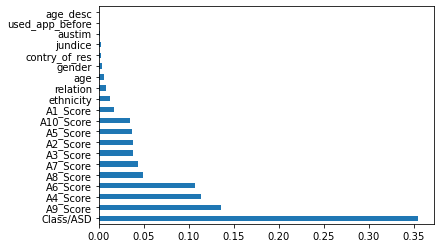

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# Get the average of the list
def Average(lst):
    return sum(lst) / len(lst)

## feature extraction
model = ExtraTreesClassifier(max_depth=3,min_samples_leaf=2)
fit = model.fit(X, Y)
print(model.feature_importances_)
print()
feat_importances = pandas.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

t = SelectFromModel(fit, prefit=True)
features = t.transform(X)
pred_features = features[:, 0:5]
pred_train, pred_test, tar_train, tar_test = train_test_split(pred_features, Y, test_size=.3, random_state=4)

# Naive Bayes Model

Confusion matrix, without normalization
[[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  1  1  0  0  0  0]
 [ 0  3  0  0  0  0  1  0  0  0  0]
 [ 0  4  0  0  0  2  1  0  0  0  0]
 [ 0  3  1  0  0  6  4  0  0  0  0]
 [ 0  0  0  0  0  8  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  5  0  3]
 [ 0  0  0  0  0  0  0  5  2  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  6]]
Normalized confusion matrix
[[0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.4   0.2   0.    0.    0.2   0.2   0.    0.    0.    0.   ]
 [0.    0.75  0.    0.    0.    0.    0.25  0.    0.    0.    0.   ]
 [0.    0.571 0.    0.    0.    0.286 0.143 0.    0.    0.    0.   ]
 [0.    0.214 0.071 0.    0.    0.429 0.286 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.8   0.2   0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.636 0.

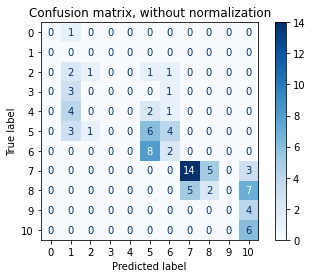

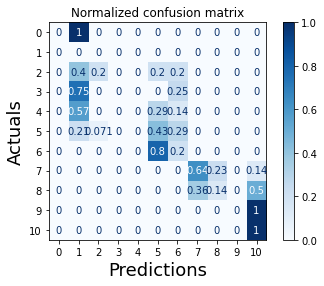

0.35261904761904767


In [5]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, auc, roc_curve

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

gnb = GaussianNB() #suitable for numeric features
gnb.fit(pred_train, np.ravel(tar_train,order='C'))
kf = KFold(n_splits=10)
gnb.fit(pred_train, tar_train)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gnb, pred_test, tar_test,
                                 #display_labels=['yes','no'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

# Print accuracy
print(Average(cross_val_score(gnb, pred_train, tar_train, cv=kf, scoring='accuracy')))

# Decision Tree Classifier Model

Confusion matrix, without normalization
[[ 0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  4  0  1  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  4  0  3  0  0  0  0]
 [ 0  0  0  5  0  9  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 15  7  0  0]
 [ 0  0  0  0  0  0  9  5  0  0]
 [ 0  0  0  0  0  0  1  3  0  0]
 [ 0  0  0  0  0  0  3  3  0  0]]
Normalized confusion matrix
[[0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.8   0.    0.2   0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.571 0.    0.429 0.    0.    0.    0.   ]
 [0.    0.    0.    0.357 0.    0.643 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.682 0.318 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.643 0.357 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.25  0.75  0.    0.   ]
 [0.    0.    0.    0.    0.    0.

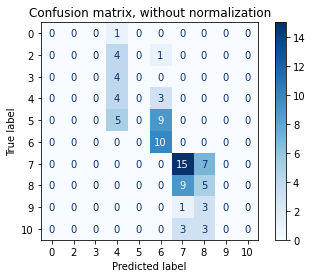

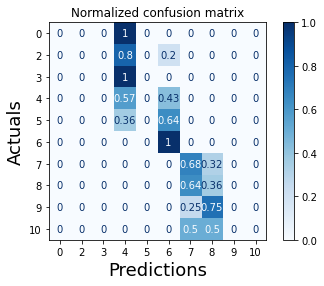

0.27809523809523806
[0.    0.    0.    0.    0.    0.223 0.    0.    0.    0.    0.    0.
 0.054 0.    0.    0.    0.    0.    0.    0.723]



<AxesSubplot:>

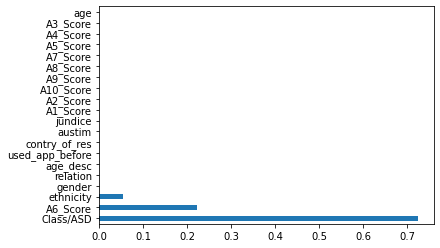

In [6]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# Reset the train/test-split
pred_train, pred_test, tar_train, tar_test = train_test_split(X, Y, test_size=.3, random_state=4)

# Train the DTC
dt = DecisionTreeClassifier(min_samples_leaf=0.2, min_samples_split=0.3)
kf = KFold(n_splits=10)
dt.fit(pred_train, tar_train)
train_pred = dt.predict(pred_train)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dt, pred_test, tar_test,
                                 #display_labels=['yes','no'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

# print acccuracy
print(Average(cross_val_score(dt, pred_train, tar_train, cv=kf, scoring='accuracy')))


# get importance
print(dt.feature_importances_)
print()
feat_importances = pandas.Series(dt.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')